In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Simulated data (1000 samples)
n_samples = 1000
seq_len = 20
dynamic_feat_dim = 2
static_feat_dim = 1

# Dynamic time series: [batch, seq_len, features]
X_dynamic = torch.randn(n_samples, seq_len, dynamic_feat_dim)

# Static features: [batch, static_features]
X_static = torch.randn(n_samples, static_feat_dim)

y = torch.randn(n_samples)

In [3]:
# Split train/test
train_size = int(0.8 * n_samples)
X_dyn_train, X_dyn_test = X_dynamic[:train_size], X_dynamic[train_size:]
X_sta_train, X_sta_test = X_static[:train_size], X_static[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [4]:
# Model
class LSTMWithStatic(nn.Module):
    def __init__(self, input_size, static_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + static_size, 1)

    def forward(self, x_dyn, x_static):
        lstm_out, _ = self.lstm(x_dyn)  # [batch, seq_len, hidden]
        last_hidden = lstm_out[:, -1, :]  # Take the last time step's output

        combined = torch.cat([last_hidden, x_static], dim=1)  # Concatenate static features
        out = self.fc(combined).squeeze()
        return out

# Initialize model
model = LSTMWithStatic(
    input_size=dynamic_feat_dim,
    static_size=static_feat_dim,
    hidden_size=64,
    num_layers=1,
)

# Train
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    model.train()
    pred = model(X_dyn_train, X_sta_train)
    loss = criterion(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 1.0455
Epoch 20, Loss: 1.0421
Epoch 30, Loss: 1.0380
Epoch 40, Loss: 1.0330
Epoch 50, Loss: 1.0270


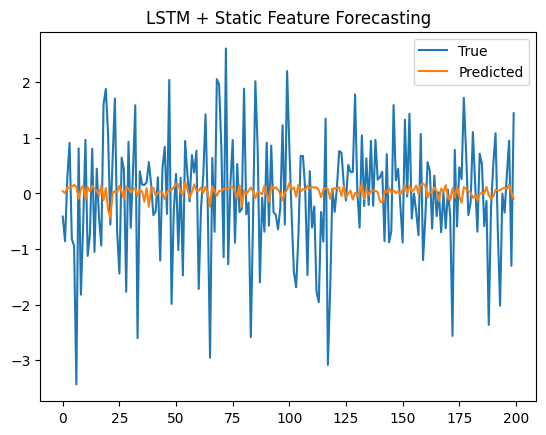

In [ ]:
# Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_dyn_test, X_sta_test)

plt.plot(y_test.numpy(), label="True")
plt.plot(preds.numpy(), label="Predicted")
plt.title("LSTM + Static Feature Forecasting")
plt.legend()
plt.show()
